# HW4_analysis_runner

In [1]:
import papermill as pm
import scrapbook as sb
import pandas as pd
from datetime import datetime, timedelta
import os

C:\ProgramData\Anaconda3\lib\site-packages\papermill\iorw.py:50: FutureWarning: pyarrow.HadoopFileSystem is deprecated as of 2.0.0, please use pyarrow.fs.HadoopFileSystem instead.
  from pyarrow import HadoopFileSystem


Run the template notebook across all tokens in the database and the last 2 complete weeks in the data base.

In [2]:
#Read all data from data/data.db in order to get list of tokens and find the last two complete weeks
db = pd.read_sql(f'''
SELECT 
    * 
FROM ohlc 
''', 'sqlite:///data/data.db')
db['ts'] = pd.to_datetime(db['ts'])

db.set_index('ts', inplace=True)

db.iloc[-1:]

,open,high,low,close,volume,volumeUSD,token,chain
ts,,,,,,,,
2021-12-15,185.07,185.78,184.5,184.89,335.307,62142.63926,COMP,ETH


In [3]:
def last_dow(d: datetime, dow: int) -> datetime:
    '''
    Gets the date of the last day of week, using datetime convention of Monday is 0 and Sunday is 6
    '''
    dow_d = d.weekday()
    days_delta = (7 - dow) + dow_d if dow_d < dow else dow_d - dow
    return d - timedelta(days=days_delta)

In [4]:
# The last two complete weeks are from 2021-11-29 to 2021-12-12
run_dates = [(last_dow(datetime(2021, 12, 1), 2) + timedelta(days=14 * x)) for x in range(1)]
tokens = db['token'].unique().tolist()
connection_string = 'sqlite:///data/data.db'

In [5]:
# Outputs are saved in HW4_outputs
base_output_folder = os.path.expanduser('HW4_outputs')

if not os.path.exists(base_output_folder):
        os.makedirs(base_output_folder)

In [6]:
# There is a problem on my end to save file with names similar to those in lecture examples. As a result I simplified to token name.
for run_date in run_dates:
    for token in tokens:
        print(f'running for {token} for date {run_date} to {run_date + timedelta(days=14)}', end='\r')
        res = pm.execute_notebook(
            'HW4_analysis_template.ipynb',
            f'{base_output_folder}/{token}.ipynb',
            parameters = {
                'from_date': f'{run_date}',
                'to_date': f'{run_date + timedelta(days=14)}',
                'token': token,
                'connection_string': connection_string
            }
        )

Executing:   0%|          | 0/20 [00:00<?, ?cell/s]

Executing:   0%|          | 0/20 [00:00<?, ?cell/s]

Executing:   0%|          | 0/20 [00:00<?, ?cell/s]

Executing:   0%|          | 0/20 [00:00<?, ?cell/s]

Executing:   0%|          | 0/20 [00:00<?, ?cell/s]

Executing:   0%|          | 0/20 [00:00<?, ?cell/s]

Executing:   0%|          | 0/20 [00:00<?, ?cell/s]

Executing:   0%|          | 0/20 [00:00<?, ?cell/s]

Executing:   0%|          | 0/20 [00:00<?, ?cell/s]

Executing:   0%|          | 0/20 [00:00<?, ?cell/s]

Executing:   0%|          | 0/20 [00:00<?, ?cell/s]

Summarize avg hourly return by run, avg volatility by run, maximum drawdown over the entire period of each run, range of last close price - first close price in a single DataFrame.

In [7]:
nbs = sb.read_notebooks('HW4_outputs')

In [8]:
pd.DataFrame([
    pd.Series({
        'token': scrap['token'].data,
        'from_date': scrap['from_date'].data,
        'to_date': scrap['to_date'].data,
        'hourly return': scrap['prices'].data['hourly return'].mean(),
        'hourly vol': scrap['prices'].data['hourly vol'].mean(),
        'MDD': scrap['prices'].data['MDD'][-1],
        'Range of last close price - first close price': scrap['prices'].data['close'][-1] - scrap['prices'].data['close'][0]}) 
    for book, scrap in nbs.notebook_scraps.items()
])

,token,from_date,to_date,hourly return,hourly vol,MDD,Range of last close price - first close price
0,AAVE,2021-12-01 00:00:00,2021-12-15 00:00:00,0.998815,0.216067,-0.187685,-88.3180
1,ADA,2021-12-01 00:00:00,2021-12-15 00:00:00,0.999450,0.224460,-0.108138,-0.2947
2,ATOM,2021-12-01 00:00:00,2021-12-15 00:00:00,0.999428,0.303370,-0.166814,-5.8280
3,AVAX,2021-12-01 00:00:00,2021-12-15 00:00:00,0.999118,0.283772,-0.145482,-35.1400
4,BTC,2021-12-01 00:00:00,2021-12-15 00:00:00,0.999534,0.157194,-0.163526,-8768.8800
5,COMP,2021-12-01 00:00:00,2021-12-15 00:00:00,0.998865,0.234725,-0.152001,-93.6200
6,CRV,2021-12-01 00:00:00,2021-12-15 00:00:00,0.998994,0.324726,-0.195640,-1.6295
7,DOT,2021-12-01 00:00:00,2021-12-15 00:00:00,0.998974,0.248345,-0.165718,-11.8820
8,ETH,2021-12-01 00:00:00,2021-12-15 00:00:00,0.999479,0.177147,-0.114836,-796.9200
9,SOL,2021-12-01 00:00:00,2021-12-15 00:00:00,0.999281,0.248466,-0.112899,-49.3260


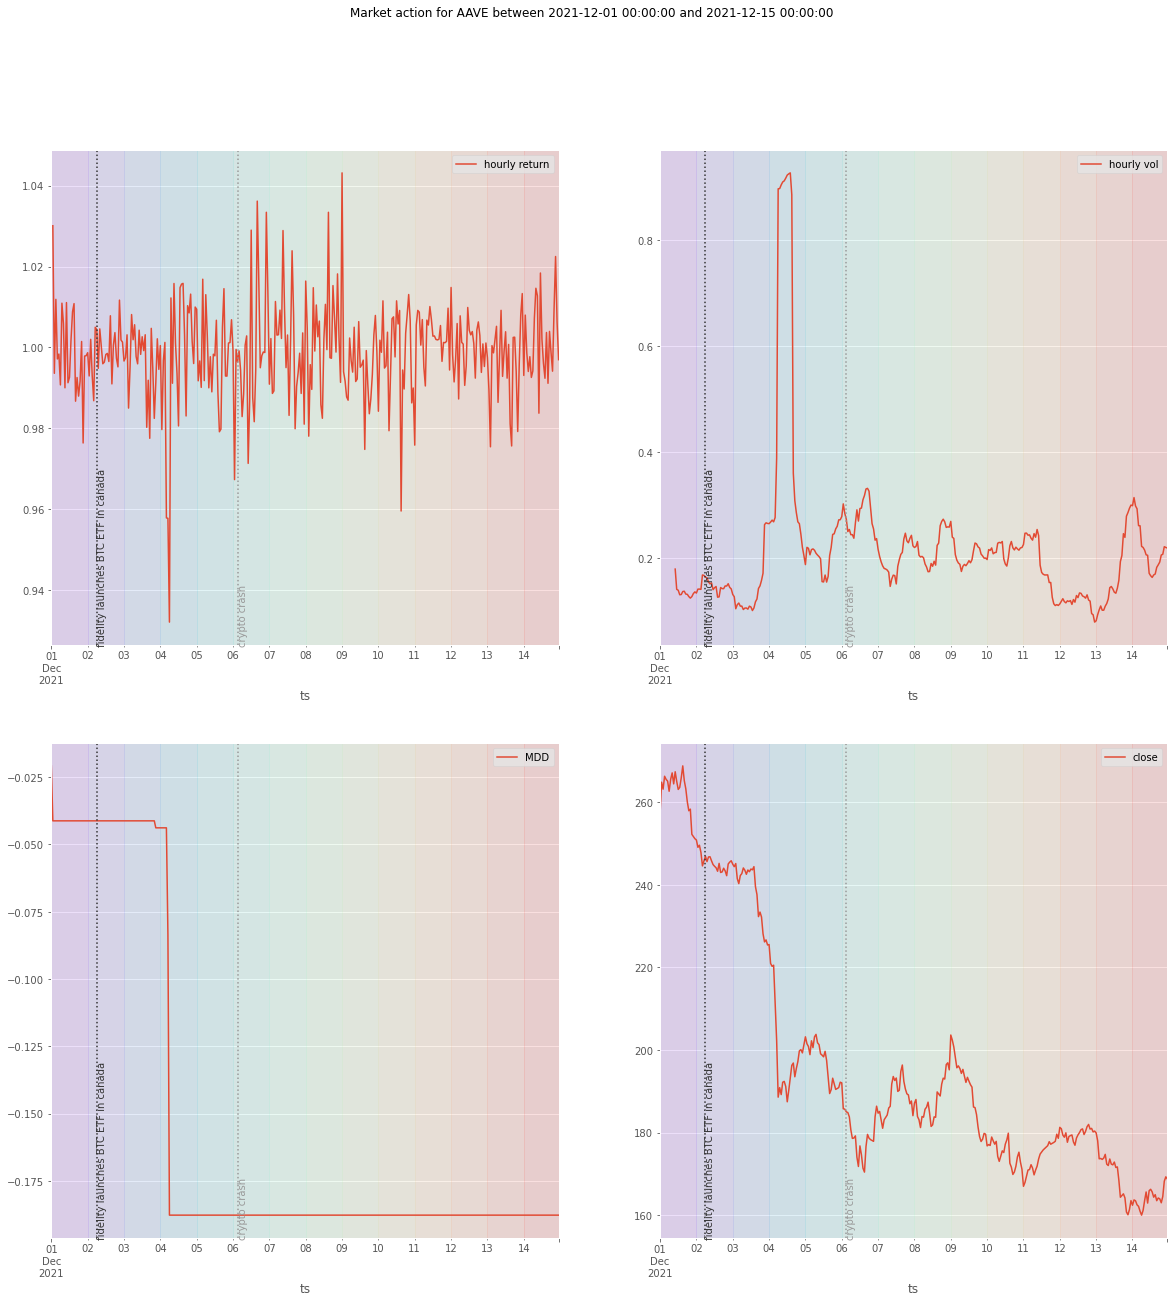

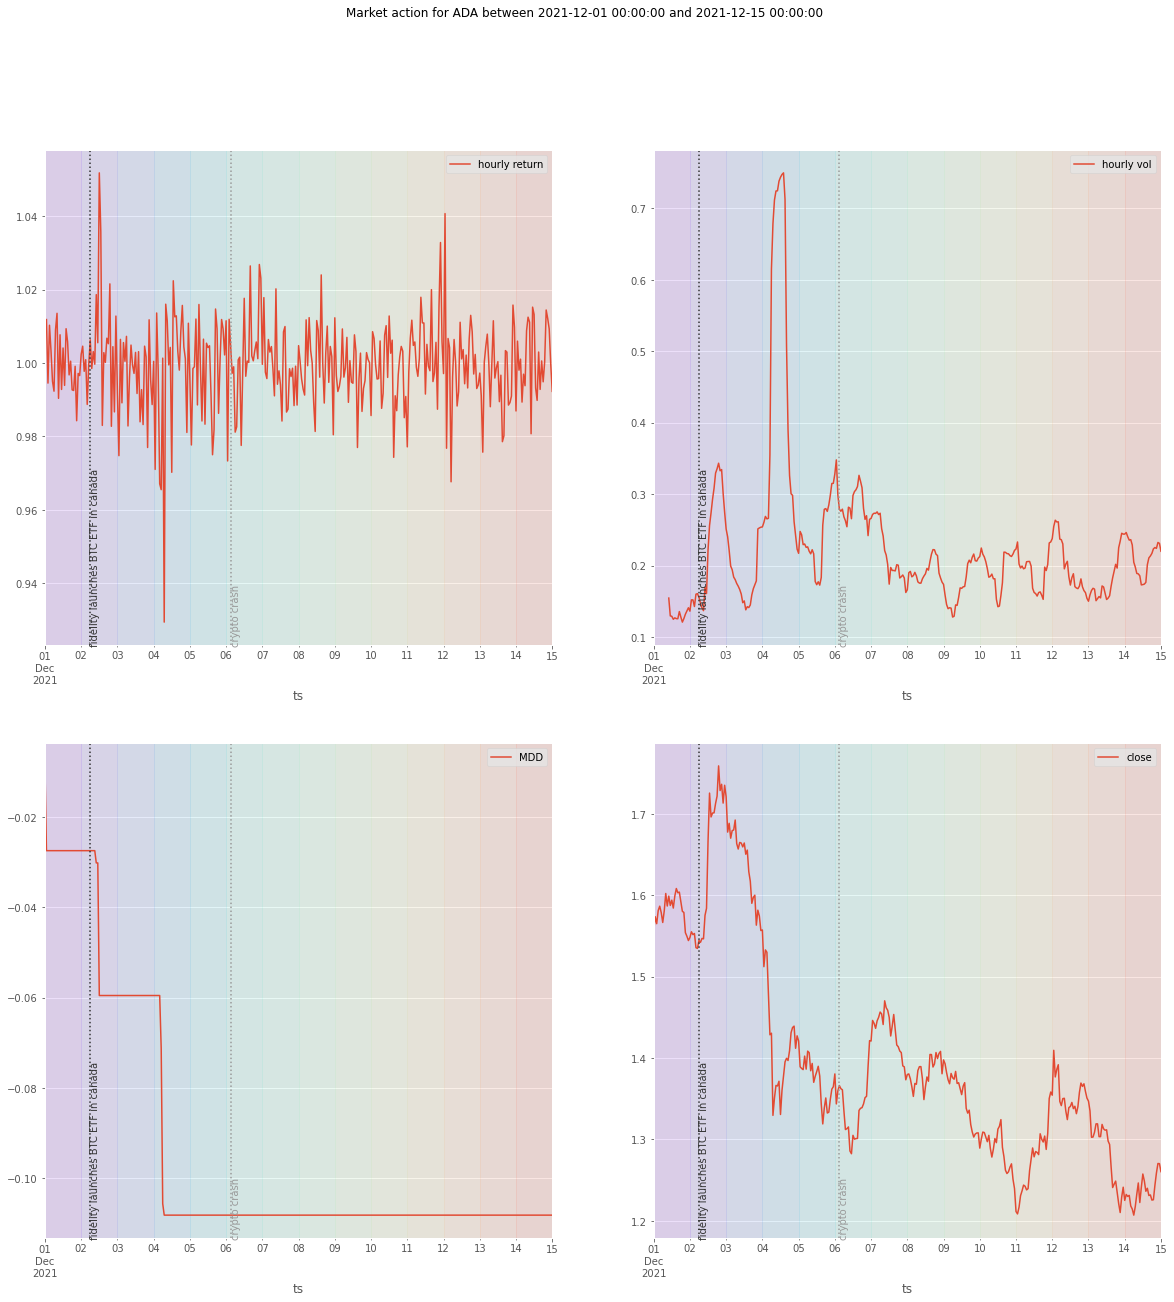

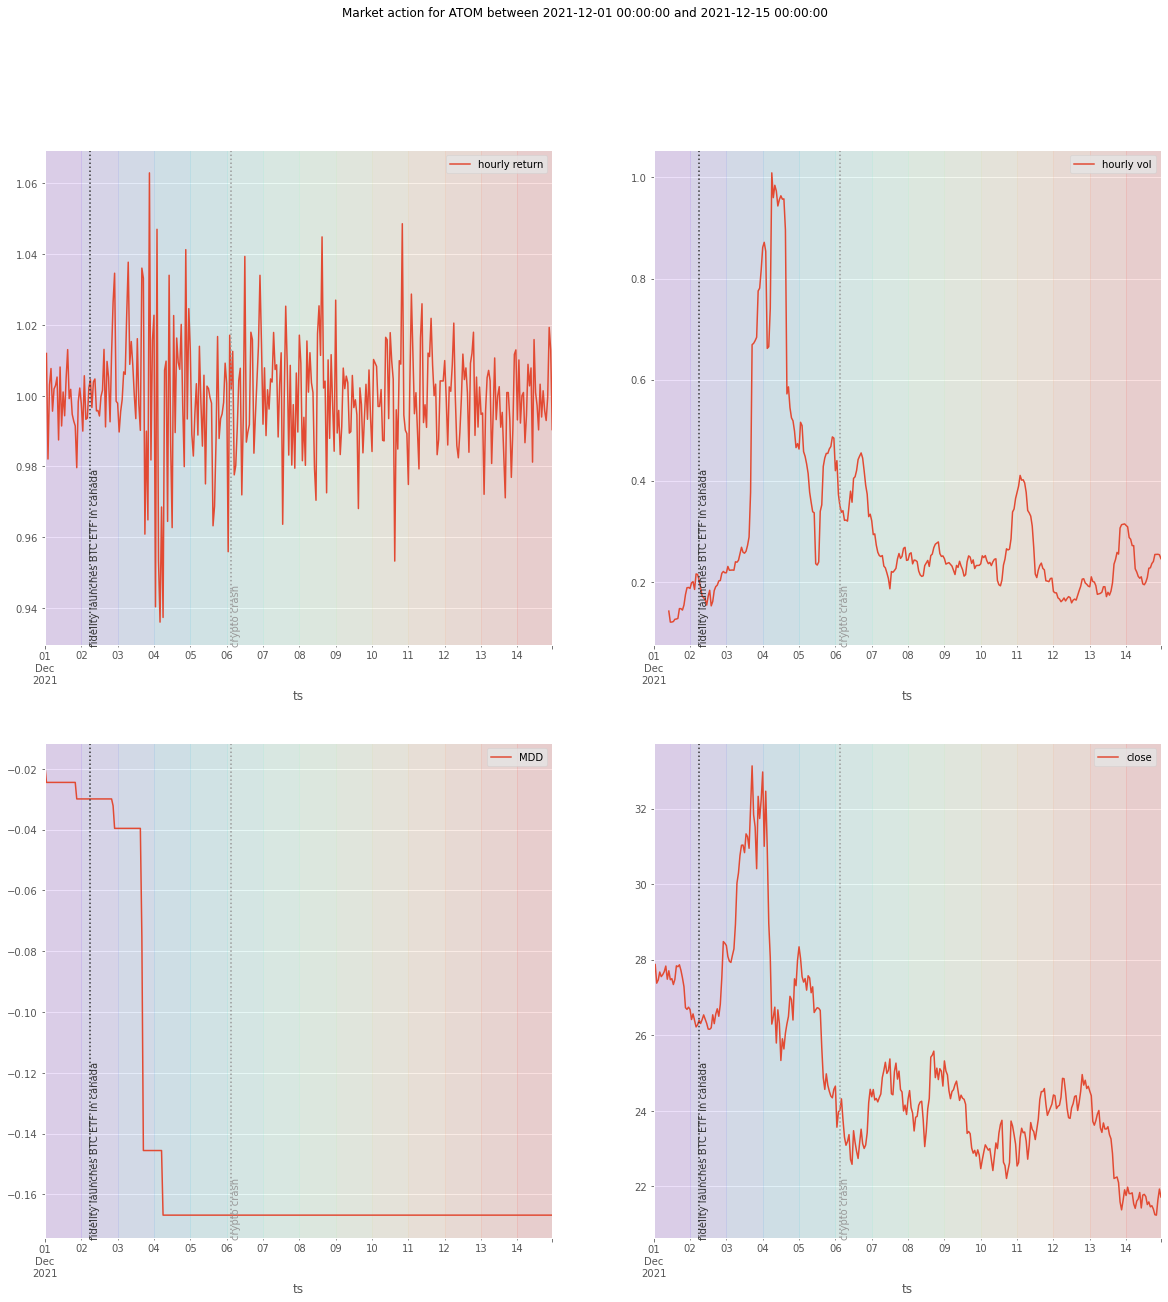

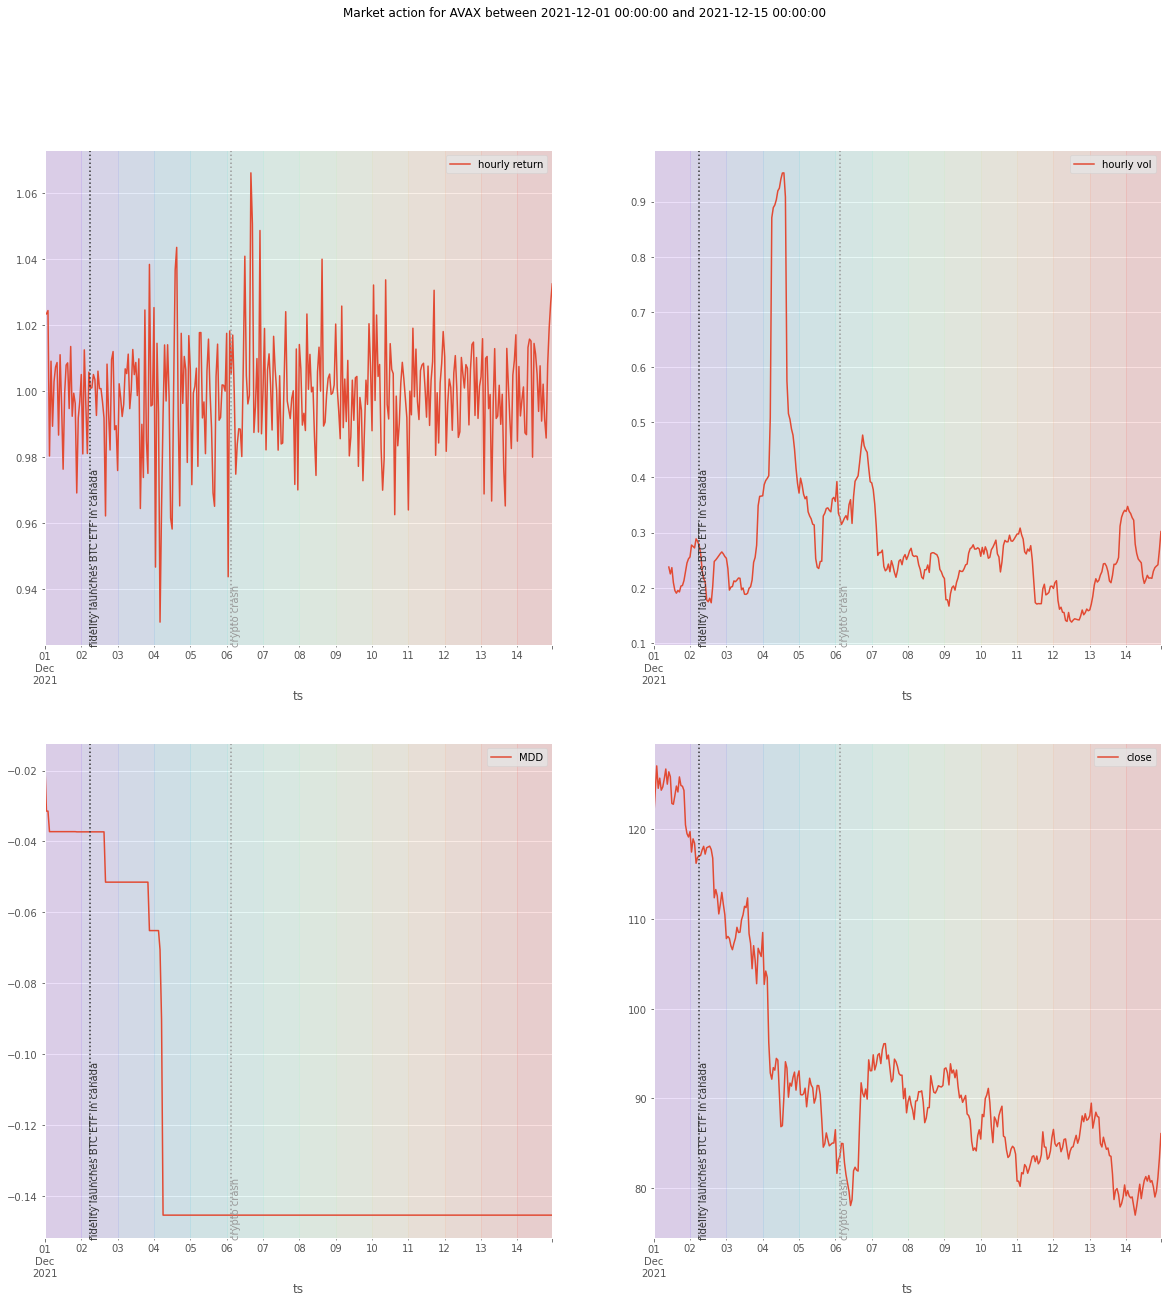

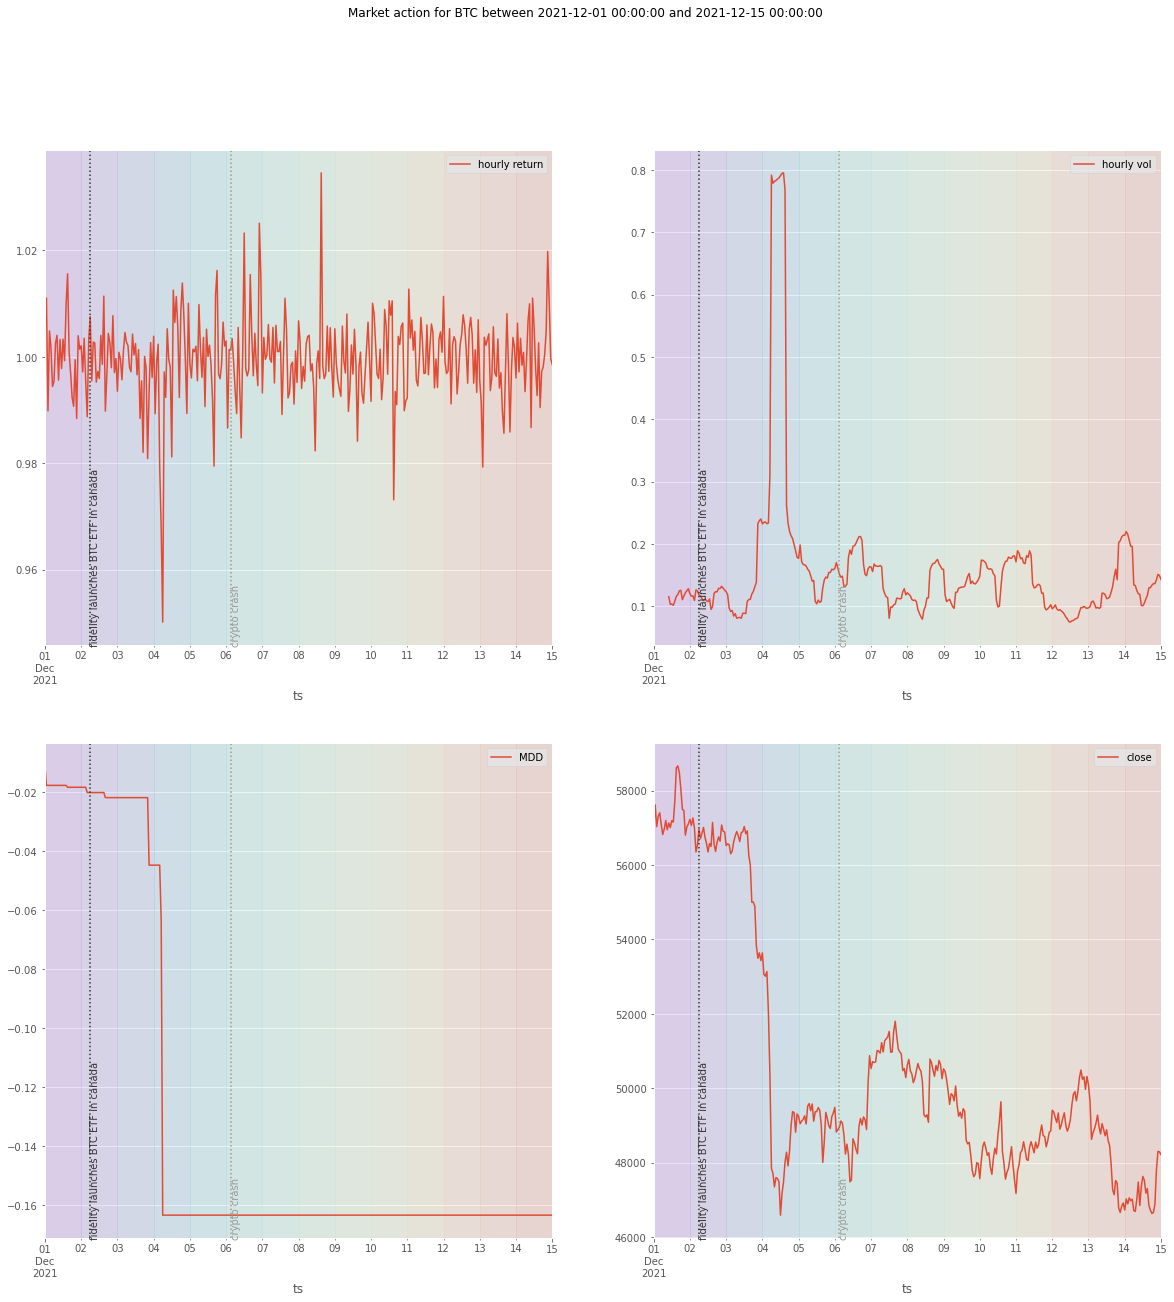

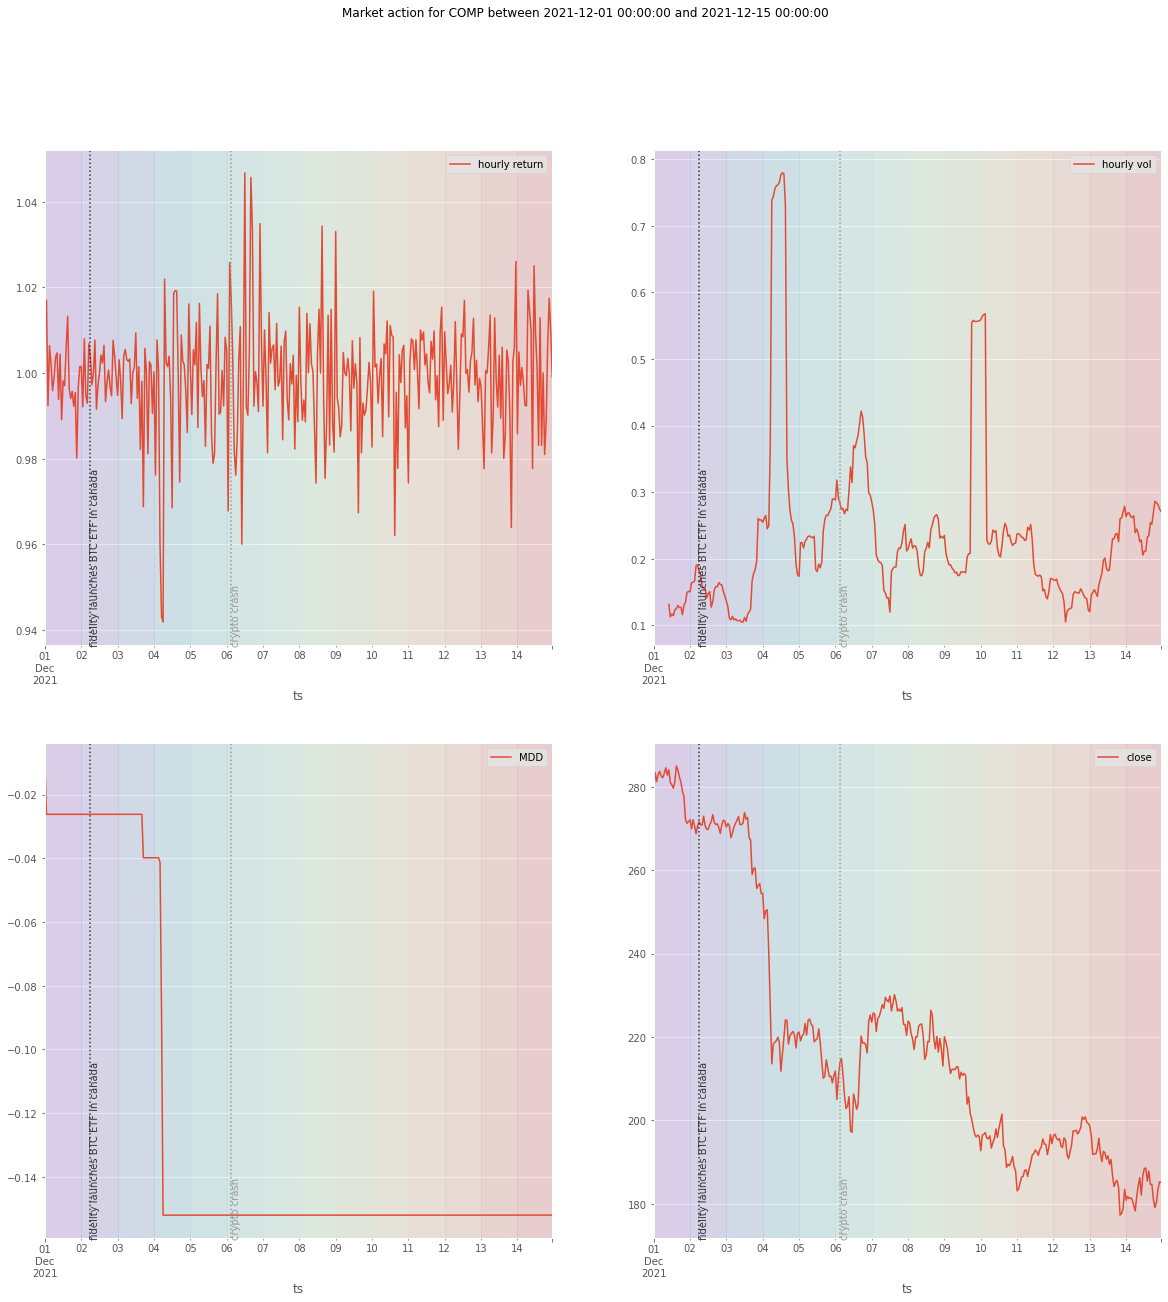

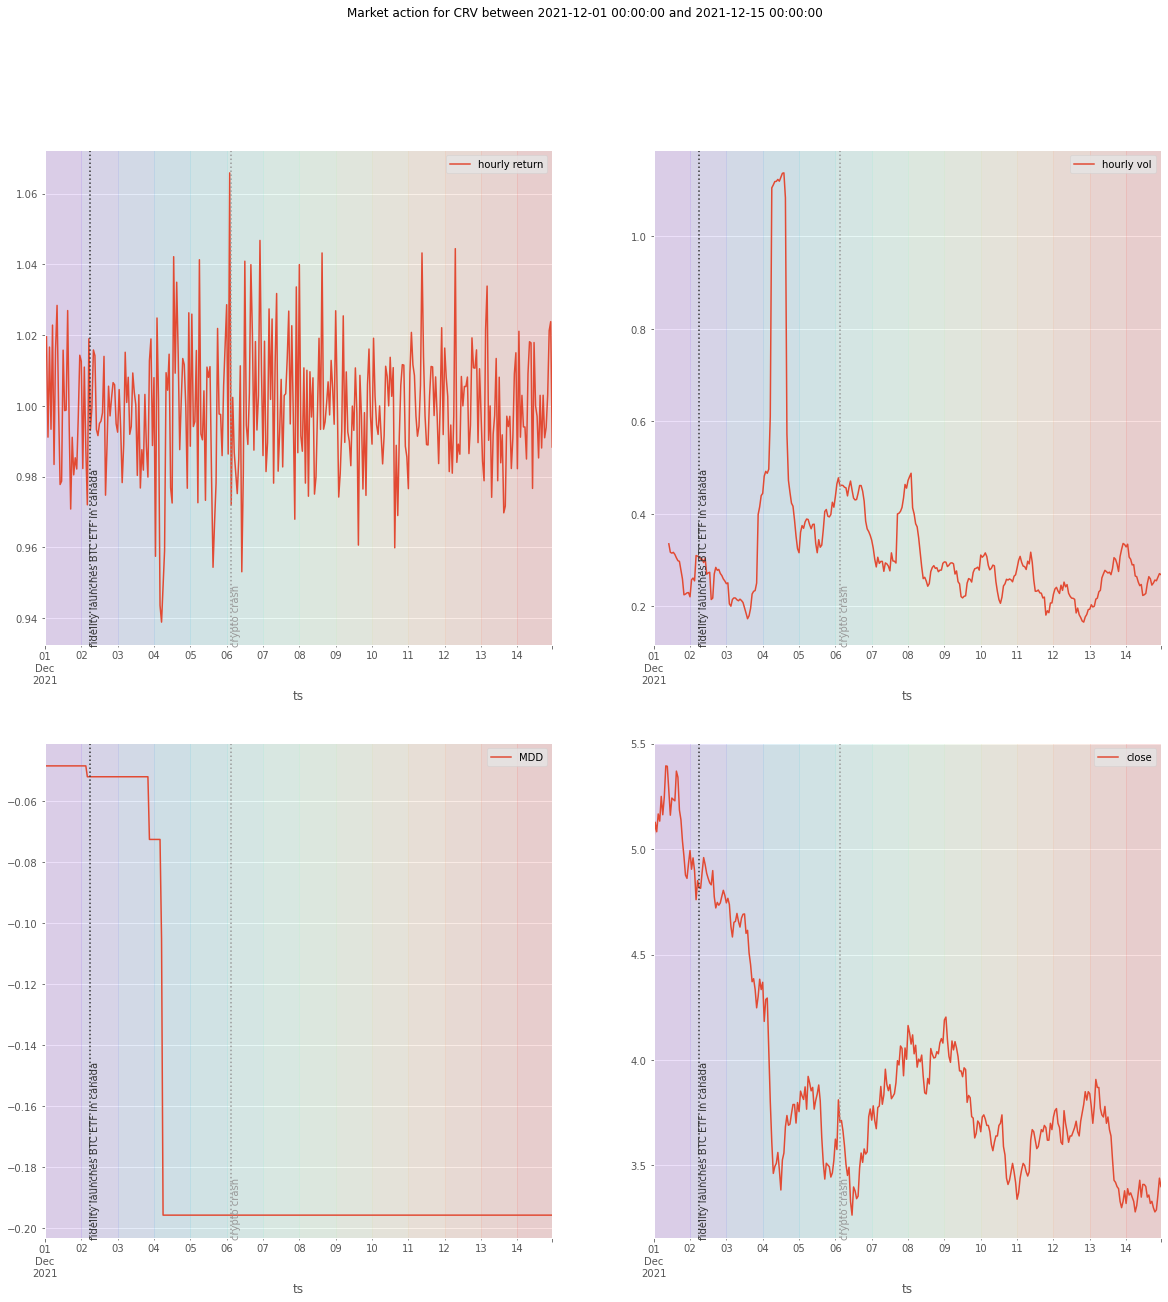

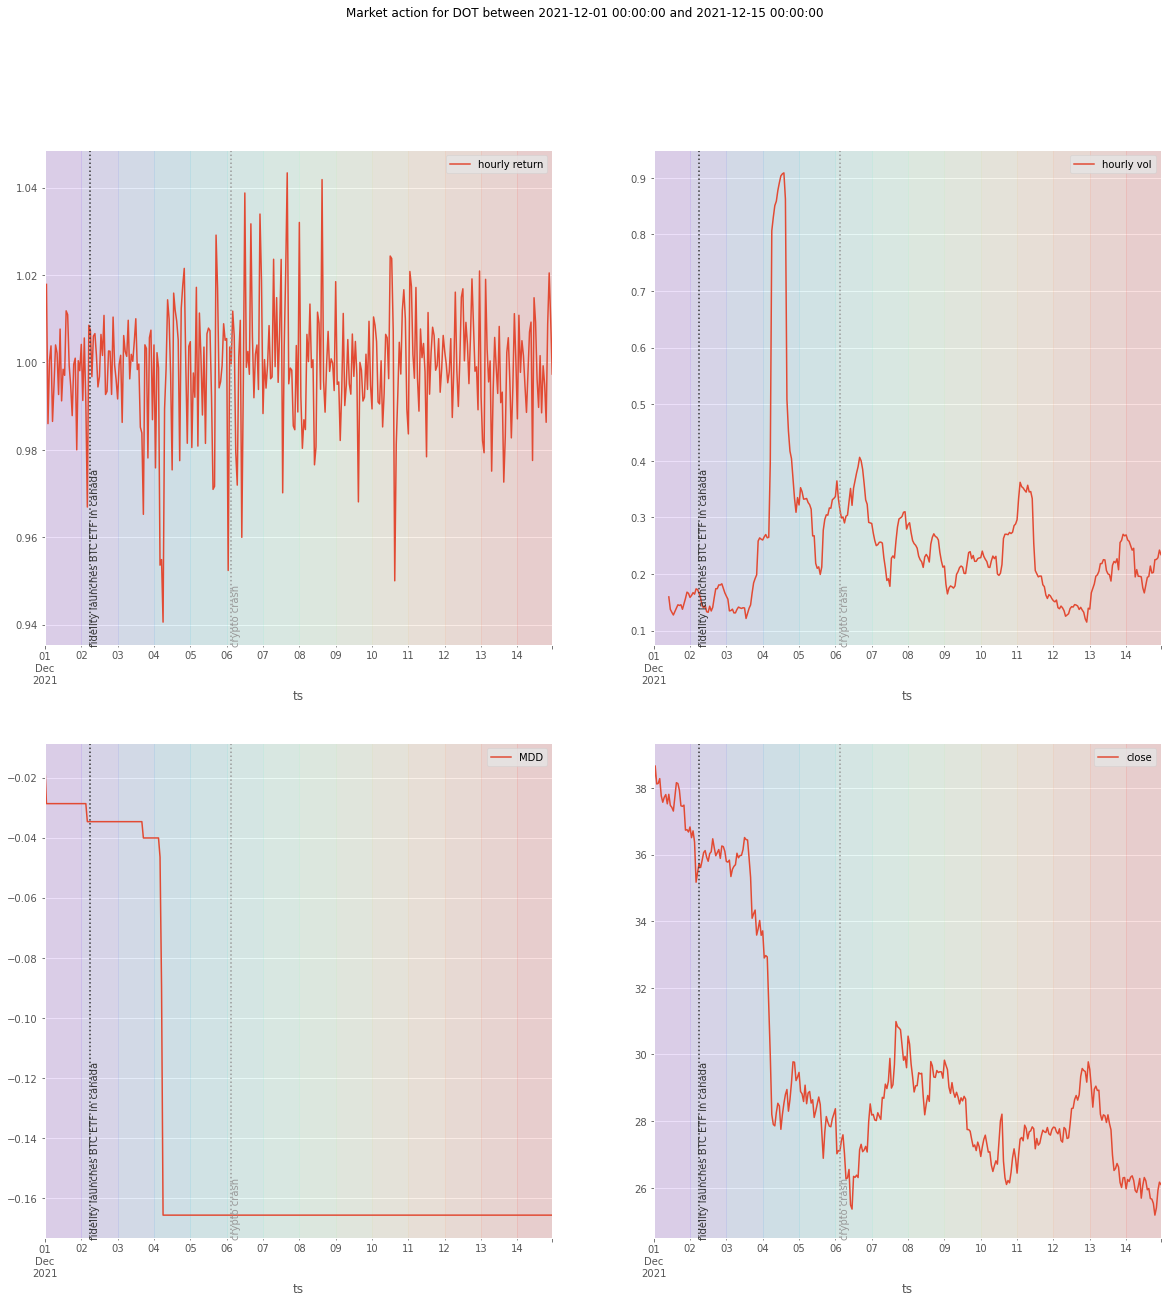

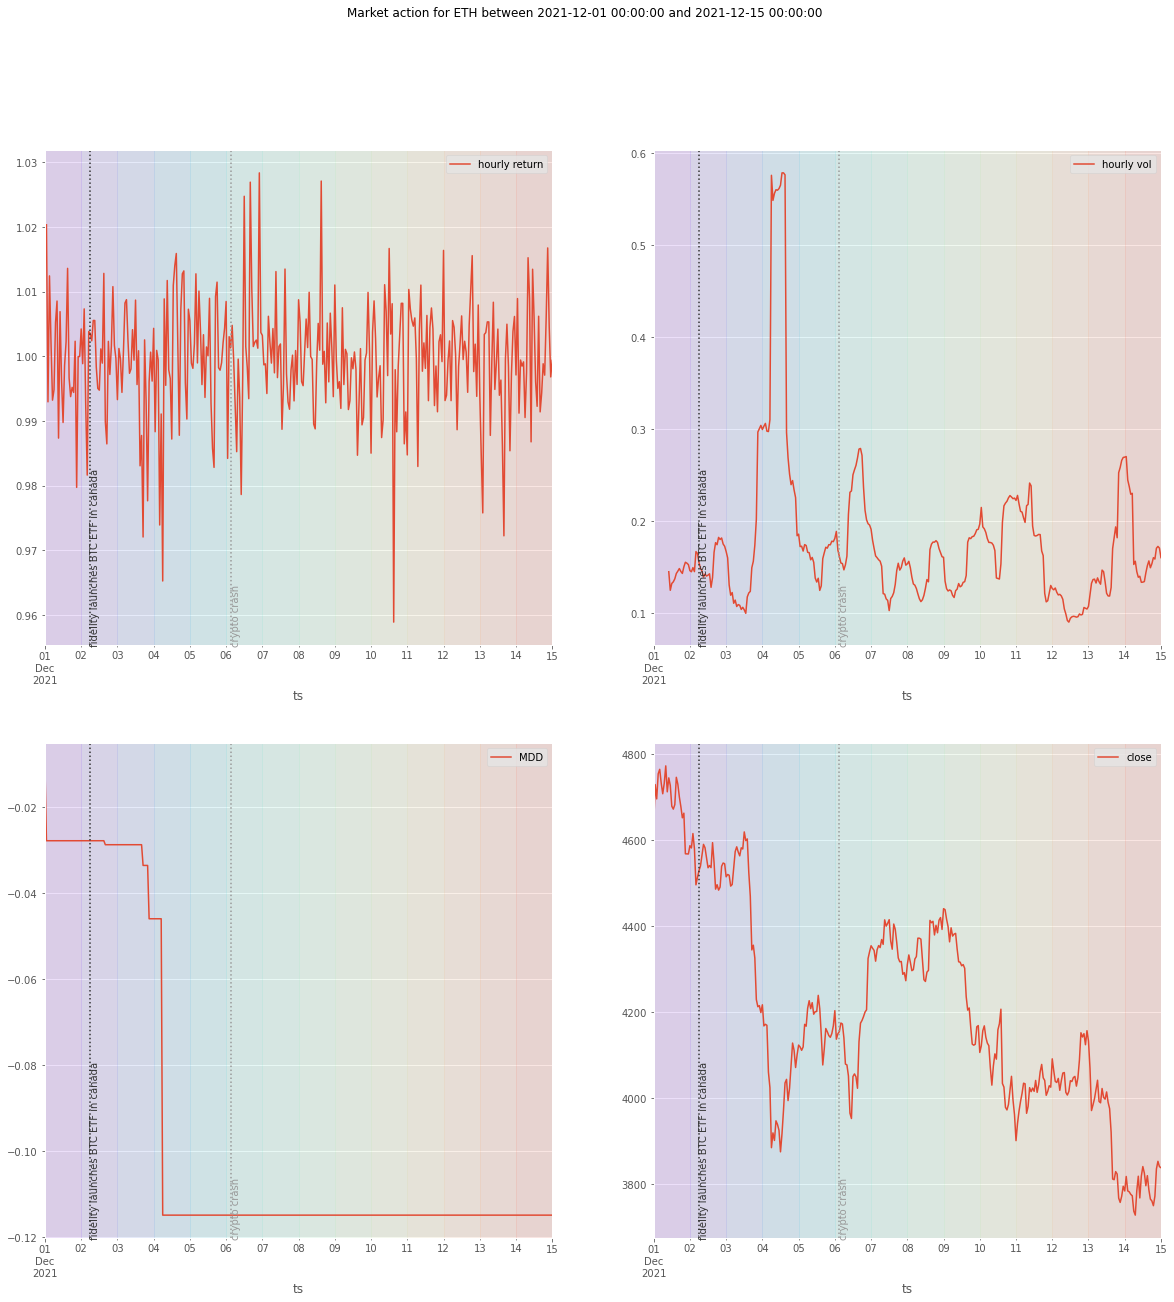

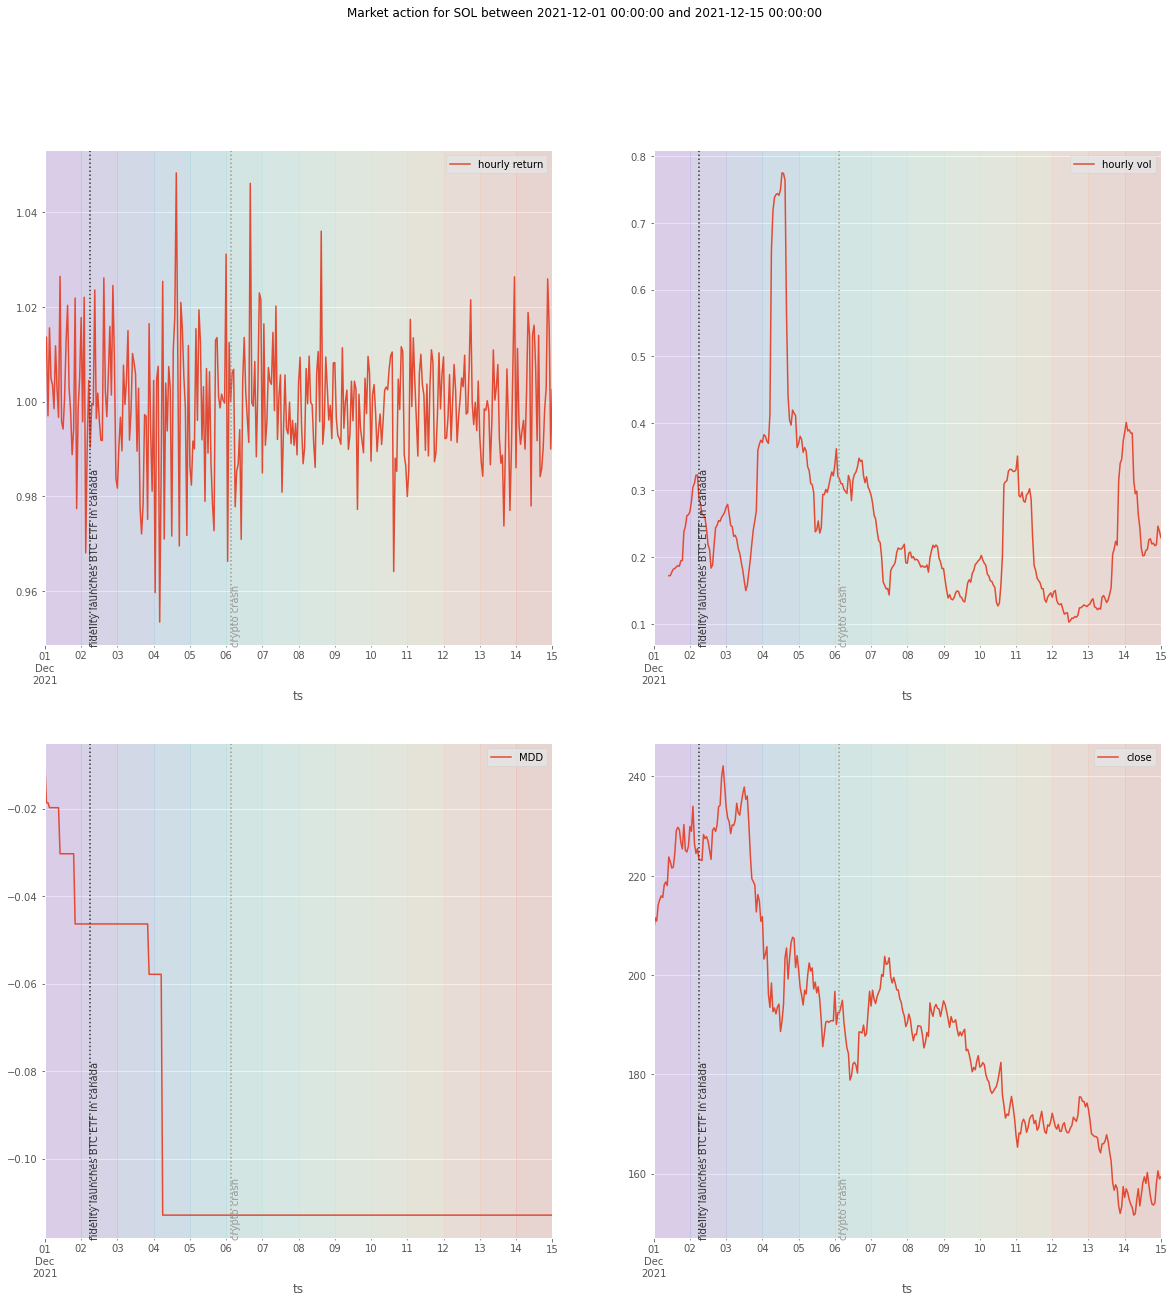

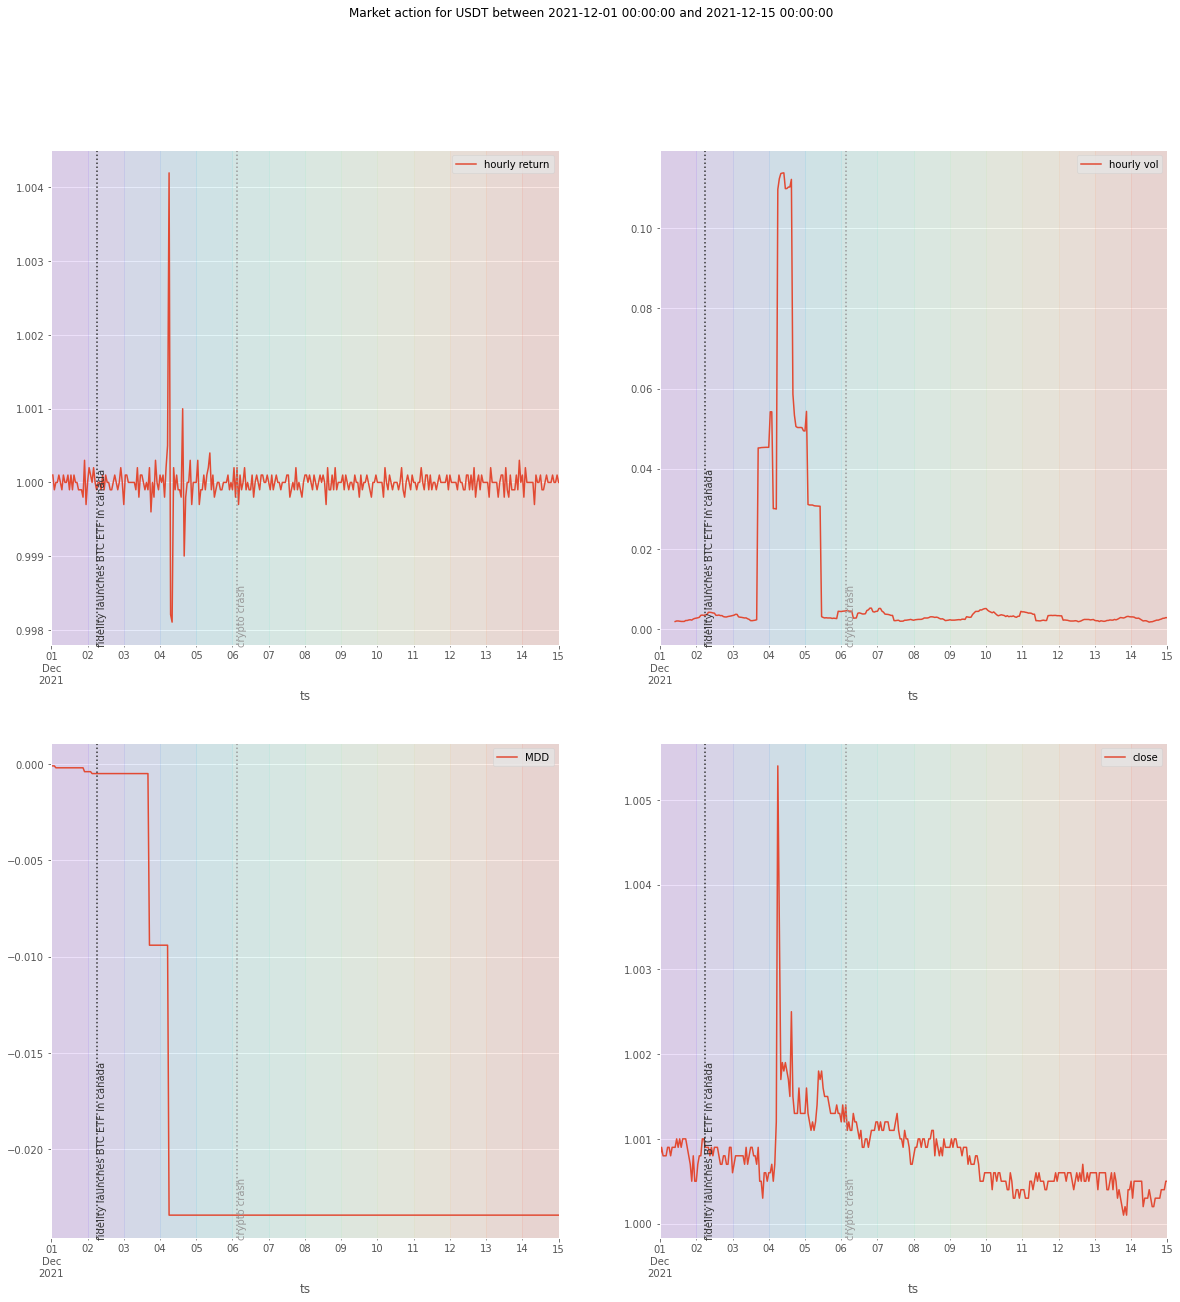

[None, None, None, None, None, None, None, None, None, None, None]

In [9]:
[nbs[nb_name].reglue('summary_plot') for nb_name in nbs]